## Example Notebook 

### Requirements

- nnfabrik, neuralpredictors, and nnvision from the sinzlab repository have to be installed/cloned

- we are using the pytorch image called `sinzlab/pytorch:v3.8-torch1.4.0-cuda10.1-dj0.12.4`
    - docker image can be found here: https://github.com/sinzlab/pytorch-docker or https://hub.docker.com/r/sinzlab/pytorch/dockerfile
    - there, the complete list of packages to be installed can be found.
    - torch >= 1.4 is required.
</br>
</br>
- All individual pickle files and the image-pickle file have to be present. The can be found on the GPU server under /var/lib/nova/sinz-shared/data


# Imports

make sure to install all required packages. dependencies are listed in the dockerfile above. If necessary, install packages within the environment


In [1]:
import torch

import nnfabrik
from nnfabrik import builder


import numpy as np
import pickle
import os

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import nnvision

# NNfabrik intro: Using the builder to build the dataloader objects, models, trainer

In [2]:
# here's where the data is on the server:
os.listdir('/data')

['image_classification', 'monkey', 'mouse', 'fetched_from_attach']

In [3]:
#### loading monkey data

basepath = '/data/monkey/toliaslab/CSRF19_V1'
neuronal_data_path = os.path.join(basepath, 'neuronal_data/')
neuronal_data_files = [neuronal_data_path+f for f in listdir(neuronal_data_path) if isfile(join(neuronal_data_path, f))]
image_file = os.path.join(basepath, 'images/CSRF19_V1_images.pickle')
image_cache_path = os.path.join(basepath, 'images/individual')


In [4]:
# Specifying the dataset function: its defined in nnvision/datasets, and has to present in the __init__.py there.
dataset_fn = 'nnvision.datasets.monkey_static_loader'
dataset_config = dict(dataset='CSRF19_V1',
                               neuronal_data_files=neuronal_data_files,
                               image_cache_path=image_cache_path,
                               crop=102,
                               subsample=1,
                               seed=1000,
                               time_bins_sum=6,
                               batch_size=128,)


In [5]:
dataloaders = builder.get_data(dataset_fn, dataset_config)

## Dataloaders

NNfabrik expects dataloaders to be nested dictionarys with actual PyTorch DataLoader Objects at the second Tier. The First Tier will be "train", "validation", and "test". The second Tier will be "session_key": DataLoader. So each dataset is either comprised of one or multiple sessions, with a session ID as the dictionary key to its dataloader.
Let's have a look:

In [7]:
dataloaders

{'train': {'3636552742293': <torch.utils.data.dataloader.DataLoader at 0x7fa4a727ea00>,
  '3636034866307': <torch.utils.data.dataloader.DataLoader at 0x7fa4a49f20d0>,
  '3635178040531': <torch.utils.data.dataloader.DataLoader at 0x7fa4a49f2f40>,
  '3637851724731': <torch.utils.data.dataloader.DataLoader at 0x7fa4a49f7ac0>,
  '3638973674012': <torch.utils.data.dataloader.DataLoader at 0x7fa4a49fae20>,
  '3637248451650': <torch.utils.data.dataloader.DataLoader at 0x7fa4a49feb80>,
  '3638885582960': <torch.utils.data.dataloader.DataLoader at 0x7fa4a4a00a90>,
  '3638373332053': <torch.utils.data.dataloader.DataLoader at 0x7fa4a4ac5940>,
  '3638541006102': <torch.utils.data.dataloader.DataLoader at 0x7fa4a4ac6910>,
  '3633364677437': <torch.utils.data.dataloader.DataLoader at 0x7fa4a4ac9700>,
  '3640011636703': <torch.utils.data.dataloader.DataLoader at 0x7fa4a4ace5b0>,
  '3631807112901': <torch.utils.data.dataloader.DataLoader at 0x7fa4a4ad35b0>,
  '3639664527524': <torch.utils.data.datalo

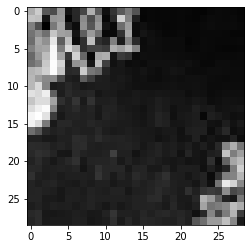

In [8]:
# here's a random image. The images are cropped to be 20x20, so it trains fast for demo purposes.
some_image = dataloaders["train"][list(dataloaders["train"].keys())[0]].dataset[:].inputs[0,0,::].cpu().numpy()
plt.imshow(some_image, cmap='gray')

In [9]:
# get first data_key
first_session_ID = list((dataloaders["train"].keys()))[0]


In [10]:
a_dataloader = dataloaders["train"][first_session_ID]
a_dataloader

In [11]:
inputs, targets = next(iter(a_dataloader))
print("image_dimensions:", inputs.shape)
print("number of neurons of that session: ", targets.shape)
print("total training batches: ", len(a_dataloader))

image_dimensions: torch.Size([128, 1, 29, 29])
number of neurons of that session:  torch.Size([128, 24])
total training batches:  77


In [12]:
# input image dimension
input_shape = dataloaders["train"][first_session_ID].dataset[:].inputs.shape
print(input_shape)
# total images = 16064
# dims: N x C x W x H

torch.Size([9803, 1, 29, 29])


In [13]:
# outpt dimensions: neuronal firing rates'
output_shape = dataloaders["train"][first_session_ID].dataset[:].targets.shape

print(output_shape)
# Output: 14 Neurons, with N spikes over 60 ms

torch.Size([9803, 24])


## Model Building

Models are built using the neuralpredictors repo from sinzlab. They consist of a convolutional core (with a user-specified number of layers), and a readout (spatial transformer readout, described in Sinz et al, 2018, NeurIPS).

### Building a model

In [14]:

model_fn = 'nnvision.models.se_core_full_gauss_readout'
model_config = {'pad_input': False,
                'stack': -1,
               'depth_separable': True,
               'input_kern': 20,
               'gamma_input': 11.2,
               'gamma_readout': 0.33,
               'hidden_dilation': 1,
               'hidden_kern': 5,
               'n_se_blocks': 0,
               'hidden_channels': 32}
model = builder.get_model(model_fn, model_config, dataloaders=dataloaders,seed=1000)
print(model)

Connecting kwilleke@134.2.168.16:3306
Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(20, 20), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_c

Above is the model description. Each session has its own readout. The Readout learns an x,y position between -1 and 1, relative to image space, and reads out from that point in feature space. THat means that the effective receptive field size of a unit in the last hidden layer will also be the receptive field size of the neuron. The x/y coordinates can be accessed like this:


In [15]:
model.core.features.layer1.conv.weight.data.shape

ModuleAttributeError: 'Sequential' object has no attribute 'conv'

#### Show example readout positions after initialization

In [ ]:
# x/y position (after random initialization, becuse the model isnt trained yet) for each neuron in that session
model.readout[first_session_ID].grid

## Building a Trainer

the trainer is taking care of the whole training process. when the trainer is built, itÄ's a function with the configuration already initialized

In [16]:
trainer_fn = 'nnvision.training.nnvision_trainer'
trainer_config = dict(max_iter=1, 
                      lr_decay_steps=4, 
                      tolerance=0.0005, 
                      patience=5,
                      verbose=False, 
                      lr_init=0.003,
                      avg_loss=False,
                      device='cuda')

trainer = builder.get_trainer(trainer_fn, trainer_config)

## Train a model

In [17]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1000)

Epoch 1: 100%|██████████| 3616/3616 [00:41<00:00, 87.87it/s] 


[001|00/05] ---> 0.21615181863307953
Restoring best model! 0.216152 ---> 0.216152


# Part Two: NNfabrik and DataJoint

Instead of using the builder to get the data/model/and trainer, we can use datajoint to manage that process for us.
There are Model, Dataset, and Trainer Tables. And each combination in those tables should in principle lead to a fully trained model.
For completeness, there is also a Seed table that stores the random seed, and a Fabrikant table, that stores the name and contact details of the creator (=Fabrikant).


In [20]:
Model()

NameError: name 'Model' is not defined

In [21]:
import datajoint as dj

schema_name = ''

dj.config['enable_python_native_blobs'] = True
dj.config['nnfabrik.schema_name'] = ""
schema = dj.schema("")

from nnfabrik.templates import TrainedModelBase
from nnfabrik.main import *


In [23]:
Fabrikant()

fabrikant_name Name of the contributor that added this entry,email e-mail address,affiliation conributor's affiliation,dj_username DataJoint username
akshay,akshaykjagadish@gmail.com,sinzlab,akjagadish
Arne Nix,arnenix@googlemail.com,sinzlab,anix
eywalker,edgar.walker@gmail.com,Sinz Lab,eywalker
kwilleke,konstantin.willeke@gmail.com,sinzlab,kwilleke
Meenakshi,mk2299@cornell.edu,Tolias lab,tolias-mk2299
Mohammad Bashiri,mohammadbashiri93@gmail.com,sinzlab,mohammad
Nikos,nikolaos.karantzas@bcm.edu,Tolias Lab,tolias-nikoskar
Your Name,your@email.com,thelab,yourname


In [ ]:
# change this entry to reflect your datajoint username
Fabrikant().insert1(dict(fabrikant_name='kwilleke',
                         email="konstantin.willeke@gmail.com",
                         affiliation='sinzlab',
                         dj_username="kwilleke"))

In [ ]:
Fabrikant()

In [ ]:
Seed().insert([{'seed':1000}])
Seed()

###  add entries for dataset, model, and trainer, with their corresponding configurations

#### Dataset

In [ ]:
# adds the dataset_function and dataset config that we defined above to the datase table
Dataset().add_entry(dataset_fn, dataset_config, dataset_comment='CSRF_V1')
Dataset()

#### Model

In [ ]:
model_fn = 'nnvision.models.se_core_full_gauss_readout'
model_config = {'pad_input': False,
                'stack': -1,
               'depth_separable': True,
               'input_kern': 20,
               'gamma_input': 11.2,
               'gamma_readout': 0.33,
               'hidden_dilation': 1,
               'hidden_kern': 5,
               'n_se_blocks': 0,
               'hidden_channels': 32,
               'gauss_type': 'isotropic'}                
Model().add_entry(model_fn, model_config, model_comment='isotropic')
Model()

In [ ]:
Trainer.delete()

In [ ]:
trainer_fn = 'nnvision.training.nnvision_trainer'
trainer_config = dict(max_iter=2, 
                      lr_decay_steps=4, 
                      tolerance=0.0005, 
                      patience=5,
                      verbose=False, 
                      lr_init=0.0045,
                      avg_loss=False,
                      device='cuda')

Trainer().add_entry(trainer_fn, trainer_config, trainer_comment="max_iter: 2")
Trainer()

In [ ]:
(Trainer&"trainer_hash='ef4dd7b8ddfb1b7bd96d43d78ff9c07e'")

####  The TrainedModel is a template, which can be found in nnfabrik.template.py

the trained model table is taking care of model training, and stores the model state in a part table. For further analyses of the trained model, one can either overwrite the TrainedModel definition by inheriting from the Base template class, or by attaching other tables to trained model.

In [ ]:
# creating the simples TrainedModel class
@schema
class TrainedModel(TrainedModelBase):
    pass

In [ ]:
TrainedModel()

as primary keys, it has the hashes of all the configurations, and it stores the score, and the output (which are defined in the respective trainer)

## Lets populate

In [ ]:
TrainedModel().populate()

In [ ]:
TrainedModel()

In [ ]:
model_hash = TrainedModel().fetch1("model_hash")

In [ ]:
# now if you want to build the model again, we can use the .load_model() function of the trained model table.
# To use the load model function, the table needs to be restricted to one Entry. 
# for example: restricting with a key:
some_key = dict(model_hash=model_hash)
TrainedModel&some_key

# How to Load a Model

In [ ]:
dataloader, model = (TrainedModel & some_key).load_model()

In [ ]:
# that is the trained model, with the state dict loaded and all. lets set to eval and start using it
model.eval()

# Parameter Extension

In [ ]:
# There's also the parameter extension, so that you can restrict with the confif objects as well.

In [ ]:
from nnfabrik.utility.dj_helpers import create_param_expansion, make_definition
ModelExpanded = create_param_expansion('nnvision.models.se_core_full_gauss_readout', Model,fn_field='model_fn', config_field='model_config')
ModelParams = schema(ModelExpanded)

In [ ]:
ModelParams()

In [ ]:
ModelParams.populate()

In [ ]:
ModelParams()

In [ ]:
# for example:
TrainedModel*ModelParams&"hidden_kern=5"

In [ ]:
# Now you can just use that for building the model:
dataloaders, model = (TrainedModel & (ModelParams & "hidden_kern=5")).load_model()